# Project by: **Krishana Choudhary**

 
**Instructor:** Dr. Abhishek Saini  
**Program:** Ph.D.  
**Roll Number:** D24170   
**Date:** 30 June 2025  


---

## 📚 References

1. Problem is taken out from deepxde website: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/elasticity.plate.html
2. **ChatGPT (OpenAI):** Assisted with conceptual clarification, coding structure, debugging.  

---

# Linear Elastostatic Equation over a 2D Square Domain

## Problem Setup

We consider a 2D linear elasticity problem on a square domain:

$$
\frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y} + f_x = 0,\quad 
\frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y} + f_y = 0,\quad 
x \in [0, 1],\ y \in [0, 1]
$$

### Constitutive Relations

$$
\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda \epsilon_{yy}, \quad 
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda \epsilon_{xx}, \quad 
\sigma_{xy} = 2\mu \epsilon_{xy}
$$

### Kinematic Relations

$$
\epsilon_{xx} = \frac{\partial u_x}{\partial x}, \quad 
\epsilon_{yy} = \frac{\partial u_y}{\partial y}, \quad 
\epsilon_{xy} = \frac{1}{2} \left( \frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x} \right)
$$

### Body Forces

$$
\begin{aligned}
f_x &= \lambda \left[ 4\pi^2 \cos(2\pi x)\sin(\pi y) - \pi \cos(\pi x) Q y^3 \right] \\
&\quad + \mu \left[ 9\pi^2 \cos(2\pi x)\sin(\pi y) - \pi \cos(\pi x) Q y^3 \right] \\
f_y &= \lambda \left[ -3 \sin(\pi x) Q y^2 + 2\pi^2 \sin(2\pi x)\cos(\pi y) \right] \\
&\quad + \mu \left[ -6 \sin(\pi x) Q y^2 + 2\pi^2 \sin(2\pi x)\cos(\pi y) + \frac{\pi^2}{4} \sin(\pi x) Q y^4 \right]
\end{aligned}
$$

### Displacement Boundary Conditions

$$
u_x(x, 0) = u_x(x, 1) = 0, \quad 
u_y(0, y) = u_y(1, y) = u_y(x, 0) = 0
$$

### Traction Boundary Conditions

$$
\sigma_{xx}(0, y) = \sigma_{xx}(1, y) = 0, \quad 
\sigma_{yy}(x, 1) = (\lambda + 2\mu) Q \sin(\pi x)
$$

### Parameters

$$
\lambda = 1, \quad \mu = 0.5, \quad Q = 4
$$

### Exact Solution

$$
u_x(x, y) = \cos(2\pi x)\sin(\pi y), \quad 
u_y(x, y) = \frac{Q}{4} \sin(\pi x) y^4
$$


## Solution Strategy using Physics-Informed Neural Networks (PINNs)

We employ Physics-Informed Neural Networks (PINNs) to solve the 2D linear elastostatic problem over a square domain. PINNs are deep learning models that incorporate the governing partial differential equations (PDEs) and boundary conditions into the training process, without requiring mesh generation or labeled data.

---

###  1. Neural Network Setup

A fully connected neural network is designed to take 2D spatial coordinates as input:

$$
(x, y) \in [0, 1] \times [0, 1]
$$

and outputs two scalar fields:

- $u_x(x, y)$: displacement in the $x$-direction  
- $u_y(x, y)$: displacement in the $y$-direction

Hence, the network learns a function:

$$
(x, y) \mapsto \begin{bmatrix} u_x(x, y) \\ u_y(x, y) \end{bmatrix}
$$

The network is trained to minimize a loss that combines physics and boundary information.

---

###  2. Physics Constraints (PDE Residuals)

We enforce the two PDEs derived from equilibrium conditions in linear elasticity:

$$
\frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y} + f_x = 0
$$

$$
\frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y} + f_y = 0
$$

To evaluate the above, the following components are calculated using automatic differentiation:

**Strain components:**

$$
\epsilon_{xx} = \frac{\partial u_x}{\partial x}, \quad 
\epsilon_{yy} = \frac{\partial u_y}{\partial y}, \quad 
\epsilon_{xy} = \frac{1}{2} \left( \frac{\partial u_x}{\partial y} + \frac{\partial u_y}{\partial x} \right)
$$

**Stress components (Hooke’s law for isotropic material):**

$$
\sigma_{xx} = (\lambda + 2\mu)\epsilon_{xx} + \lambda \epsilon_{yy}
$$

$$
\sigma_{yy} = (\lambda + 2\mu)\epsilon_{yy} + \lambda \epsilon_{xx}
$$

$$
\sigma_{xy} = 2\mu \epsilon_{xy}
$$

These expressions are inserted into the PDEs and evaluated at randomly sampled collocation points in the domain to compute the **PDE residual loss**, denoted $\mathcal{L}_{\mathrm{PDE}}$.

---

###  3. Boundary Conditions

We implement both **essential** (Dirichlet) and **natural** (Neumann) boundary conditions.

**Displacement BCs:**

$$
u_x(x, 0) = u_x(x, 1) = 0, \quad 
u_y(0, y) = u_y(1, y) = u_y(x, 0) = 0
$$

These are imposed by directly penalizing the squared difference between network predictions and specified values, forming the **displacement loss** $\mathcal{L}_{\mathrm{disp}}$.

**Traction BCs:**

$$
\sigma_{xx}(0, y) = \sigma_{xx}(1, y) = 0, \quad 
\sigma_{yy}(x, 1) = (\lambda + 2\mu) Q \sin(\pi x)
$$

Traction loss terms $\mathcal{L}_{\mathrm{traction}}$ are included by computing stresses from the network-predicted displacements and penalizing mismatch with the target tractions.

---

###  4. Loss Function

The total loss combines all physics and boundary components:

$$
\mathcal{L}_{\mathrm{total}} = \mathcal{L}_{\mathrm{PDE}} + \mathcal{L}_{\mathrm{disp}} + \mathcal{L}_{\mathrm{traction}}
$$

Each component is computed by sampling points:

- Inside the domain (for PDE residuals)  
- On Dirichlet and Neumann boundaries (for BCs)

---

###  5. Training Process

The model is trained using a gradient-based optimizer (e.g., Adam) to minimize the total loss. The network learns to output displacement fields $u_x(x, y)$ and $u_y(x, y)$ that:

- Satisfy the equilibrium equations  
- Match the specified boundary values and tractions  
- Generalize smoothly across the domain

---

###  6. Evaluation

After training, the network predictions are compared to the known analytical solution:

$$
u_x(x, y) = \cos(2\pi x) \sin(\pi y), \quad 
u_y(x, y) = \frac{Q}{4} \sin(\pi x) y^4
$$

The comparison is made using:

- Visual plots (e.g., surface/contour plots)  
- Quantitative error metrics (e.g., $L_2$ norm)

This validates the accuracy and reliability of the PINN-based approach for solving PDE-governed physical systems.


In [18]:
###############################################################################
# Importing necessary modules

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Checking for device and setting it up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if device.type == 'cuda' else 'CPU'
print(f"Using device: {device} ({device_name})")
##############################################################################



###############################################################################
# Defining the PINN model

class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) model with:
    - 2 input neurons: x and y coordinates
    - 4 hidden layers, each with 50 neurons and Tanh activation
    - 2 output neurons: u_x (displacement in x), u_y (displacement in y)
    """
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)  # Output: (u_x, u_y)
        )

    def forward(self, x, y):
        """Forward pass through the network."""
        inputs = torch.cat([x, y], dim=1)  # Concatenate x and y along columns
        return self.hidden(inputs)


################################################################################
# Function to compute strain and stress

def compute_strain_stress(x, y, model, lambda_, mu):
    """
    Compute strain and stress tensor components from predicted displacements using the trained PINN model.

    Args:
        x (torch.Tensor): x-coordinates [N, 1], with requires_grad=True
        y (torch.Tensor): y-coordinates [N, 1], with requires_grad=True
        model (nn.Module): Trained PINN model predicting displacements [u_x, u_y]
        lambda_ (float): First Lamé parameter
        mu (float): Second Lamé parameter (shear modulus)

    Returns:
        sigma_xx (Tensor): Normal stress in x-direction
        sigma_yy (Tensor): Normal stress in y-direction
        sigma_xy (Tensor): Shear stress (xy component)
    """
    # Enable gradient tracking for autograd
    x.requires_grad = True
    y.requires_grad = True

    # Predict displacements using the model
    u = model(x, y)         # Shape: [N, 2]
    u_x = u[:, 0:1]         # u_x: Displacement in x-direction
    u_y = u[:, 1:2]         # u_y: Displacement in y-direction

    # --------------------------------------------------------------------------------------------
    # Compute first-order derivatives (strain components)
    # -----------------------------------
    u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]  # ∂u_x/∂x
    u_x_y = torch.autograd.grad(u_x, y, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]  # ∂u_x/∂y
    u_y_x = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]  # ∂u_y/∂x
    u_y_y = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]  # ∂u_y/∂y

    # --------------------------------------------------------------------------------------------
    # Linear strain tensor (small deformation assumption)
    # -----------------------------------
    epsilon_xx = u_x_x                               # ε_xx
    epsilon_yy = u_y_y                               # ε_yy
    epsilon_xy = 0.5 * (u_x_y + u_y_x)               # ε_xy = (∂u_x/∂y + ∂u_y/∂x) / 2

    # -------------------------------------------------------------------------------------------------
    # Stress tensor using Hooke’s law (isotropic material)
    # -----------------------------------
    sigma_xx = (lambda_ + 2 * mu) * epsilon_xx + lambda_ * epsilon_yy
    sigma_yy = (lambda_ + 2 * mu) * epsilon_yy + lambda_ * epsilon_xx
    sigma_xy = 2 * mu * epsilon_xy

    return sigma_xx, sigma_yy, sigma_xy




###############################################################################
# PDE Residual Computation

def pde_res(model, x, y, Q, lambda_, mu):
    """
    Computes the residuals of the linear elasticity PDE system at interior points.

    The governing equations are:
        ∇·σ + f = 0
    where σ is the Cauchy stress tensor and f = [f_x, f_y] is the body force vector.

    Args:
        model     (nn.Module): Trained PINN model predicting displacements (u_x, u_y)
        x, y      (Tensor): Interior coordinates with shape [N, 1]
        Q         (float): A parameter in the body force definition
        lambda_, mu (float): Lamé constants (material parameters)

    Returns:
        res_x (Tensor): PDE residual in x-direction
        res_y (Tensor): PDE residual in y-direction
    """

    # Enable autograd for spatial coordinates
    x.requires_grad_(True)
    y.requires_grad_(True)

    #  Compute stress components from predicted displacements
    sigma_xx, sigma_yy, sigma_xy = compute_strain_stress(x, y, model, lambda_, mu)

    #   Compute divergence of stress tensor
    sigma_xx_x = torch.autograd.grad(sigma_xx, x, grad_outputs=torch.ones_like(sigma_xx), create_graph=True)[0]  # ∂σ_xx/∂x
    sigma_xy_y = torch.autograd.grad(sigma_xy, y, grad_outputs=torch.ones_like(sigma_xy), create_graph=True)[0]  # ∂σ_xy/∂y

    sigma_xy_x = torch.autograd.grad(sigma_xy, x, grad_outputs=torch.ones_like(sigma_xy), create_graph=True)[0]  # ∂σ_xy/∂x
    sigma_yy_y = torch.autograd.grad(sigma_yy, y, grad_outputs=torch.ones_like(sigma_yy), create_graph=True)[0]  # ∂σ_yy/∂y

    #  Define body forces f_x and f_y 
    pi = torch.tensor(np.pi, dtype=torch.float32, device=x.device)

    fx = (
        lambda_ * (4 * pi**2 * torch.cos(2 * pi * x) * torch.sin(pi * y) - pi * torch.cos(pi * x) * Q * y**3) +
        mu * (9 * pi**2 * torch.cos(2 * pi * x) * torch.sin(pi * y) - pi * torch.cos(pi * x) * Q * y**3)
    )

    fy = (
        lambda_ * (-3 * torch.sin(pi * x) * Q * y**2 + 2 * pi**2 * torch.sin(2 * pi * x) * torch.cos(pi * y)) +
        mu * (-6 * torch.sin(pi * x) * Q * y**2 + 2 * pi**2 * torch.sin(2 * pi * x) * torch.cos(pi * y) + 
              (pi**2 / 4) * torch.sin(pi * x) * Q * y**4)
    )

    # PDE residuals (∇·σ + f)
    res_x = sigma_xx_x + sigma_xy_y + fx   # Residual in x-direction
    res_y = sigma_xy_x + sigma_yy_y + fy   # Residual in y-direction

    return res_x, res_y



################################################################################
# Dirichlet Boundary Conditions (Displacements)

def displacement_bc_loss(model, lambda_, mu, device):
    """
    Compute mean squared error loss to enforce Dirichlet boundary conditions on the domain edges.

    Dirichlet BCs applied:
        - u_x = 0 on y = 0 and y = 1  (bottom and top edges)
        - u_y = 0 on x = 0 and x = 1  (left and right edges)
        - u_y = 0 also enforced on y = 0 (bottom edge)

    Args:
        model     : PINN model that predicts (u_x, u_y)
        lambda_, mu: Lamé constants (not used here but kept for consistency)
        device    : CUDA or CPU device

    Returns:
        total_loss (Tensor): MSE loss from all Dirichlet boundary constraints
    """
    pi = torch.tensor(np.pi, device=device)  # just initialized but not used here

    # Number of discrete boundary samples
    n_bc = 100

    # Create boundary sampling points on [0,1]
    x_bc = torch.linspace(0, 1, n_bc).view(-1, 1).to(device)
    y_bc = torch.linspace(0, 1, n_bc).view(-1, 1).to(device)

    # Coordinates for edges
    y0 = torch.zeros_like(x_bc)   # y = 0
    y1 = torch.ones_like(x_bc)    # y = 1
    x0 = torch.zeros_like(y_bc)   # x = 0
    x1 = torch.ones_like(y_bc)    # x = 1

    # u_x = 0 on y = 0 and y = 1
    loss_ux_y0 = (model(x_bc, y0)[:, 0:1] ** 2).mean()
    loss_ux_y1 = (model(x_bc, y1)[:, 0:1] ** 2).mean()

    # u_y = 0 on y = 0, x = 0, x = 1
    loss_uy_y0 = (model(x_bc, y0)[:, 1:2] ** 2).mean()
    loss_uy_x0 = (model(x0, y_bc)[:, 1:2] ** 2).mean()
    loss_uy_x1 = (model(x1, y_bc)[:, 1:2] ** 2).mean()

    # Total loss from all Dirichlet constraints
    return loss_ux_y0 + loss_ux_y1 + loss_uy_y0 + loss_uy_x0 + loss_uy_x1


################################################################################
# Neumann Boundary Conditions (Traction)

def traction_bc_loss(model, lambda_, mu, Q, device):
    """
    Compute MSE loss to enforce Neumann (traction) boundary conditions.

    Conditions enforced:
        - σ_xx(0, y) = 0    (left edge: x=0)
        - σ_xx(1, y) = 0    (right edge: x=1)
        - σ_yy(x, 1) = (λ + 2μ) * Q * sin(πx)  (top edge: y=1)

    Args:
        model     : Trained PINN model
        lambda_, mu: Lamé constants
        Q         : Load parameter
        device    : CPU or CUDA device

    Returns:
        total_loss (Tensor): Combined MSE loss from all traction BCs
    """
    pi = torch.tensor(np.pi, device=device)
    n_bc = 100

    # Boundary sampling points
    y = torch.linspace(0, 1, n_bc).view(-1, 1).to(device)
    x = torch.linspace(0, 1, n_bc).view(-1, 1).to(device)

    # Traction-free conditions on vertical edges:
    # σ_xx(0, y) = 0
    sigma_xx_0, _, _ = compute_strain_stress(torch.zeros_like(y), y, model, lambda_, mu)
    # σ_xx(1, y) = 0
    sigma_xx_1, _, _ = compute_strain_stress(torch.ones_like(y), y, model, lambda_, mu)

    # Applied traction on top edge y = 1:
    # σ_yy(x, 1) = (λ + 2μ) Q sin(πx)
    _, sigma_yy_1, _ = compute_strain_stress(x, torch.ones_like(x), model, lambda_, mu)
    target = (lambda_ + 2 * mu) * Q * torch.sin(pi * x)

    # Compute squared errors for each BC
    loss_sigma_xx_left  = (sigma_xx_0 ** 2).mean()
    loss_sigma_xx_right = (sigma_xx_1 ** 2).mean()
    loss_sigma_yy_top   = ((sigma_yy_1 - target) ** 2).mean()

    # Total traction loss
    return loss_sigma_xx_left + loss_sigma_xx_right + loss_sigma_yy_top


################################################################################
#  Training the PINN Model

# Hyperparameters and material constants
epochs = 5000                 # Number of training epochs
lr = 1e-3                     # Learning rate
lambda_ = 1.0                 # Lamé's first parameter
mu = 0.5                      # Lamé's second parameter (shear modulus)
Q = 4.0                       # Load parameter (used in body force expressions)

# Initialize model and optimizer
model = PINN().to(device)                                # Move model to device
optimizer = optim.Adam(model.parameters(), lr=lr)        # Adam optimizer

# Sample N interior points from domain [0, 1] × [0, 1]
N_interior = 1000
x_int = torch.rand(N_interior, 1).to(device)
y_int = torch.rand(N_interior, 1).to(device)

#  Training loop
for epoch in range(epochs + 1):
    model.train()
    optimizer.zero_grad()

    #  Compute residuals of PDE from physics
    res_x, res_y = pde_res(model, x_int, y_int, Q, lambda_, mu)
    loss_pde = (res_x**2).mean() + (res_y**2).mean()     # Physics loss from equilibrium equations

    #  Compute loss from Dirichlet boundary conditions
    loss_disp = displacement_bc_loss(model, lambda_, mu, device)

    #  Compute loss from Neumann (traction) boundary conditions
    loss_trac = traction_bc_loss(model, lambda_, mu, Q, device)

    #  Total loss: physics + displacement BC + traction BC
    loss = loss_pde + loss_disp + loss_trac
    loss.backward()
    optimizer.step()

    #  Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total Loss: {loss.item():.6e} | "
              f"PDE: {loss_pde.item():.3e} | DispBC: {loss_disp.item():.3e} | TracBC: {loss_trac.item():.3e}")


Using device: cpu (CPU)
Epoch     0 | Total Loss: 2.072158e+03 | PDE: 2.040e+03 | DispBC: 1.054e-01 | TracBC: 3.199e+01
Epoch   500 | Total Loss: 1.609617e+00 | PDE: 7.119e-01 | DispBC: 3.234e-01 | TracBC: 5.743e-01
Epoch  1000 | Total Loss: 4.659097e-01 | PDE: 2.445e-01 | DispBC: 9.341e-02 | TracBC: 1.280e-01
Epoch  1500 | Total Loss: 7.286401e-01 | PDE: 6.043e-01 | DispBC: 3.892e-02 | TracBC: 8.542e-02
Epoch  2000 | Total Loss: 8.464599e-02 | PDE: 4.888e-02 | DispBC: 1.528e-02 | TracBC: 2.049e-02
Epoch  2500 | Total Loss: 5.206628e-02 | PDE: 3.368e-02 | DispBC: 7.573e-03 | TracBC: 1.081e-02
Epoch  3000 | Total Loss: 3.540666e-02 | PDE: 2.439e-02 | DispBC: 4.632e-03 | TracBC: 6.384e-03
Epoch  3500 | Total Loss: 2.614566e-02 | PDE: 1.868e-02 | DispBC: 3.253e-03 | TracBC: 4.217e-03
Epoch  4000 | Total Loss: 2.215733e-01 | PDE: 2.006e-01 | DispBC: 2.713e-03 | TracBC: 1.828e-02
Epoch  4500 | Total Loss: 1.579108e-02 | PDE: 1.121e-02 | DispBC: 2.116e-03 | TracBC: 2.466e-03
Epoch  5000 | To

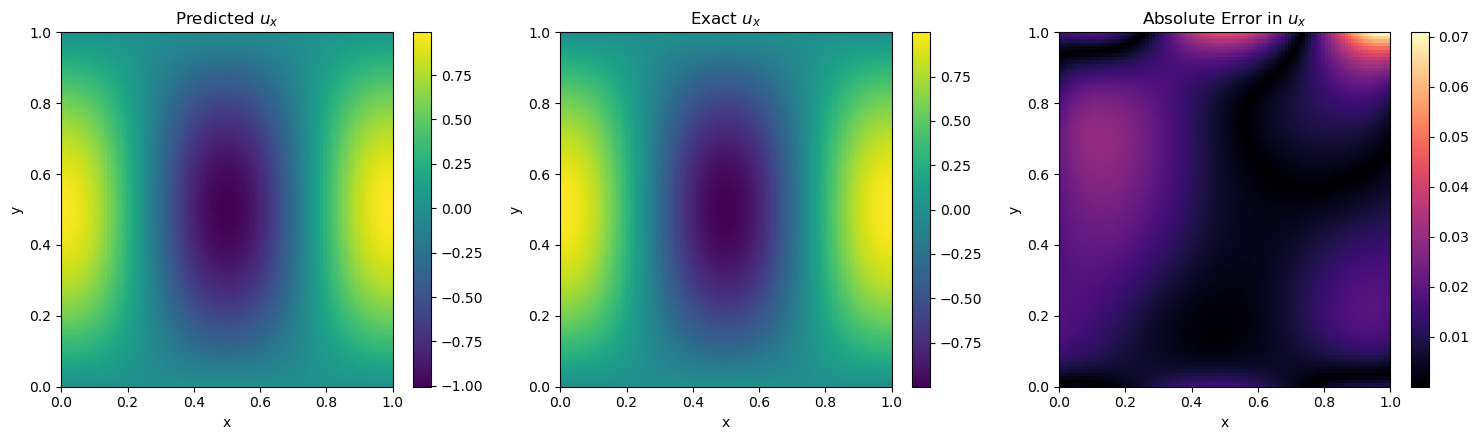

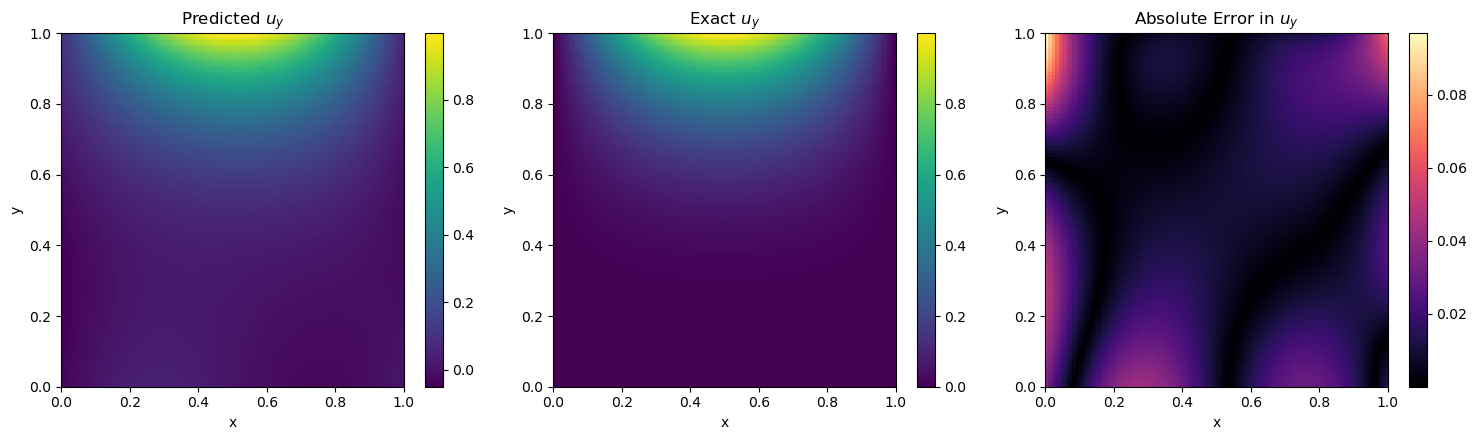

In [17]:
################################################################################
#  Post-Processing and Visualization
################################################################################

import matplotlib.pyplot as plt
import numpy as np
import torch

#  Set the grid resolution for visual evaluation
n_grid = 100
x_vals = torch.linspace(0, 1, n_grid)  # x ∈ [0, 1]
y_vals = torch.linspace(0, 1, n_grid)  # y ∈ [0, 1]

#  Create a 2D meshgrid of the domain (n_grid × n_grid)
X, Y = torch.meshgrid(x_vals, y_vals, indexing='xy')

#  Flatten the meshgrid to feed into the model as test input
x_test = X.reshape(-1, 1).to(device)
y_test = Y.reshape(-1, 1).to(device)

#  Use the trained model to predict displacements at each (x, y)
model.eval()
with torch.no_grad():
    u_pred = model(x_test, y_test)        # Output shape: [n_grid², 2]
    u_x_pred = u_pred[:, 0:1]             # Extract u_x
    u_y_pred = u_pred[:, 1:2]             # Extract u_y

#  Compute exact analytical solution for comparison
pi = torch.tensor(np.pi, device=device)
Q = 4.0
u_x_exact = torch.cos(2 * pi * x_test) * torch.sin(pi * y_test)
u_y_exact = torch.sin(pi * x_test) * Q * (y_test ** 4) / 4

#  Reshape predictions and exact values into 2D (grid) format
u_x_pred_np = u_x_pred.view(n_grid, n_grid).cpu().numpy()
u_y_pred_np = u_y_pred.view(n_grid, n_grid).cpu().numpy()
u_x_exact_np = u_x_exact.view(n_grid, n_grid).cpu().numpy()
u_y_exact_np = u_y_exact.view(n_grid, n_grid).cpu().numpy()

#  Compute absolute errors for both displacement components
error_ux = np.abs(u_x_pred_np - u_x_exact_np)
error_uy = np.abs(u_y_pred_np - u_y_exact_np)

# Function: Compare predicted, exact, and error using imshow
def plot_comparison(pred, exact, error, title_pred, title_exact, title_error):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

    # Plot predicted field
    im1 = axes[0].imshow(pred, origin='lower', extent=[0, 1, 0, 1],
                         cmap='viridis', aspect='auto')
    axes[0].set_title(title_pred)
    fig.colorbar(im1, ax=axes[0])

    # Plot exact solution
    im2 = axes[1].imshow(exact, origin='lower', extent=[0, 1, 0, 1],
                         cmap='viridis', aspect='auto')
    axes[1].set_title(title_exact)
    fig.colorbar(im2, ax=axes[1])

    # Plot absolute error
    im3 = axes[2].imshow(error, origin='lower', extent=[0, 1, 0, 1],
                         cmap='magma', aspect='auto')
    axes[2].set_title(title_error)
    fig.colorbar(im3, ax=axes[2])

    # Label all axes
    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    plt.tight_layout()
    plt.show()

#  Visualize u_x: predicted vs exact vs error
plot_comparison(
    u_x_pred_np, u_x_exact_np, error_ux,
    title_pred=r"Predicted $u_x$", 
    title_exact=r"Exact $u_x$", 
    title_error=r"Absolute Error in $u_x$"
)

#  Visualize u_y: predicted vs exact vs error
plot_comparison(
    u_y_pred_np, u_y_exact_np, error_uy,
    title_pred=r"Predicted $u_y$", 
    title_exact=r"Exact $u_y$", 
    title_error=r"Absolute Error in $u_y$"
)
